In [2]:
import numpy as np
import math
import pandas as pd
import seaborn as sns
import itertools
import matplotlib
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 300;
import scipy.io
from scipy.stats import qmc


In [6]:

desiredTotalCFDCases = 256
inputParamNames = [
    'mach',
    'reynolds',
    'freestreamTemp',
    'lengthFromFlare',
    'deformationLength',
    'deformationAmplitudeMode1',
    'deformationAmplitudeMode2',
]

l_bounds = [3, 9e4, 80, 0, 19, -4, -4]
u_bounds = [8, 1e6, 150, 2, 76, 4, 4]

seed = 5

m = math.log2(desiredTotalCFDCases)
m = math.ceil(m)

printDict = {
    True: 'HAVE',
    False: 'HAVE NOT'
}

def is_power_of_two(number : int) -> bool:
    while number != 1:
        if number % 2:
            return False
        number /= 2
    return True

powerBool = is_power_of_two(number=desiredTotalCFDCases) # creates boolean if the number of cases creates a power of 2 for the low discrepancy sequence  

print(f'You {printDict[powerBool]} selected a power of 2 for number of cases.') 
if not powerBool:
    print(f'Based on your desired number of CFD cases, you\'ll need to run {(2**m)} cases to safely use LDS. \nTo run less cases, you could instead run {(2**(m-1))} CFD cases\nTo run more cases, you could instead run {(2**(m+1))} CFD cases\n')

sampler = qmc.Sobol(d=len(l_bounds), scramble=False,seed = seed)
sample = sampler.random_base2(m=m)
print(f'discrepancy of sample: {qmc.discrepancy(sample)}. seed: {seed}')
sample = qmc.scale(sample, l_bounds, u_bounds)
sample.shape

You HAVE selected a power of 2 for number of cases.
discrepancy of sample: 0.001169470214798185. seed: 5


(256, 7)

In [7]:

new_data=np.array([
    [4, 5e5, 128, 1, 38, 0, 2],
    [4, 5e5, 128, 1, 38, 2, 0],
    [4, 5e5, 128, 1, 38, 0, -2],
    [4, 5e5, 128, 1, 38, -2, 0],
    [4, 5e5, 128, 0, 0, 0, 0],
    [7, 133000, 93.3, 0, 0, 0, 0],
    [7, 133000, 93.3, 1.2, 58, 3, 0],
    [7, 133000, 93.5, 0.86, 58, 3, 0],
    [7, 133000, 93.5, 0.5, 58, 3, 0],
    [7, 133000, 93.5, 0.1, 58, 3, 0]
    ])

sampleArray = np.concatenate((sample,new_data))

print(f'You have {sampleArray.shape[1]} number of input variables and a total of {sampleArray.shape[0]} number of cases.')
print(f'Shape of your input sample array: {sampleArray.shape}')

df = pd.DataFrame(data = sampleArray, columns = inputParamNames)
df.to_csv('./inputVariables.csv')

You have 7 number of input variables and a total of 266 number of cases.
Shape of your input sample array: (266, 7)


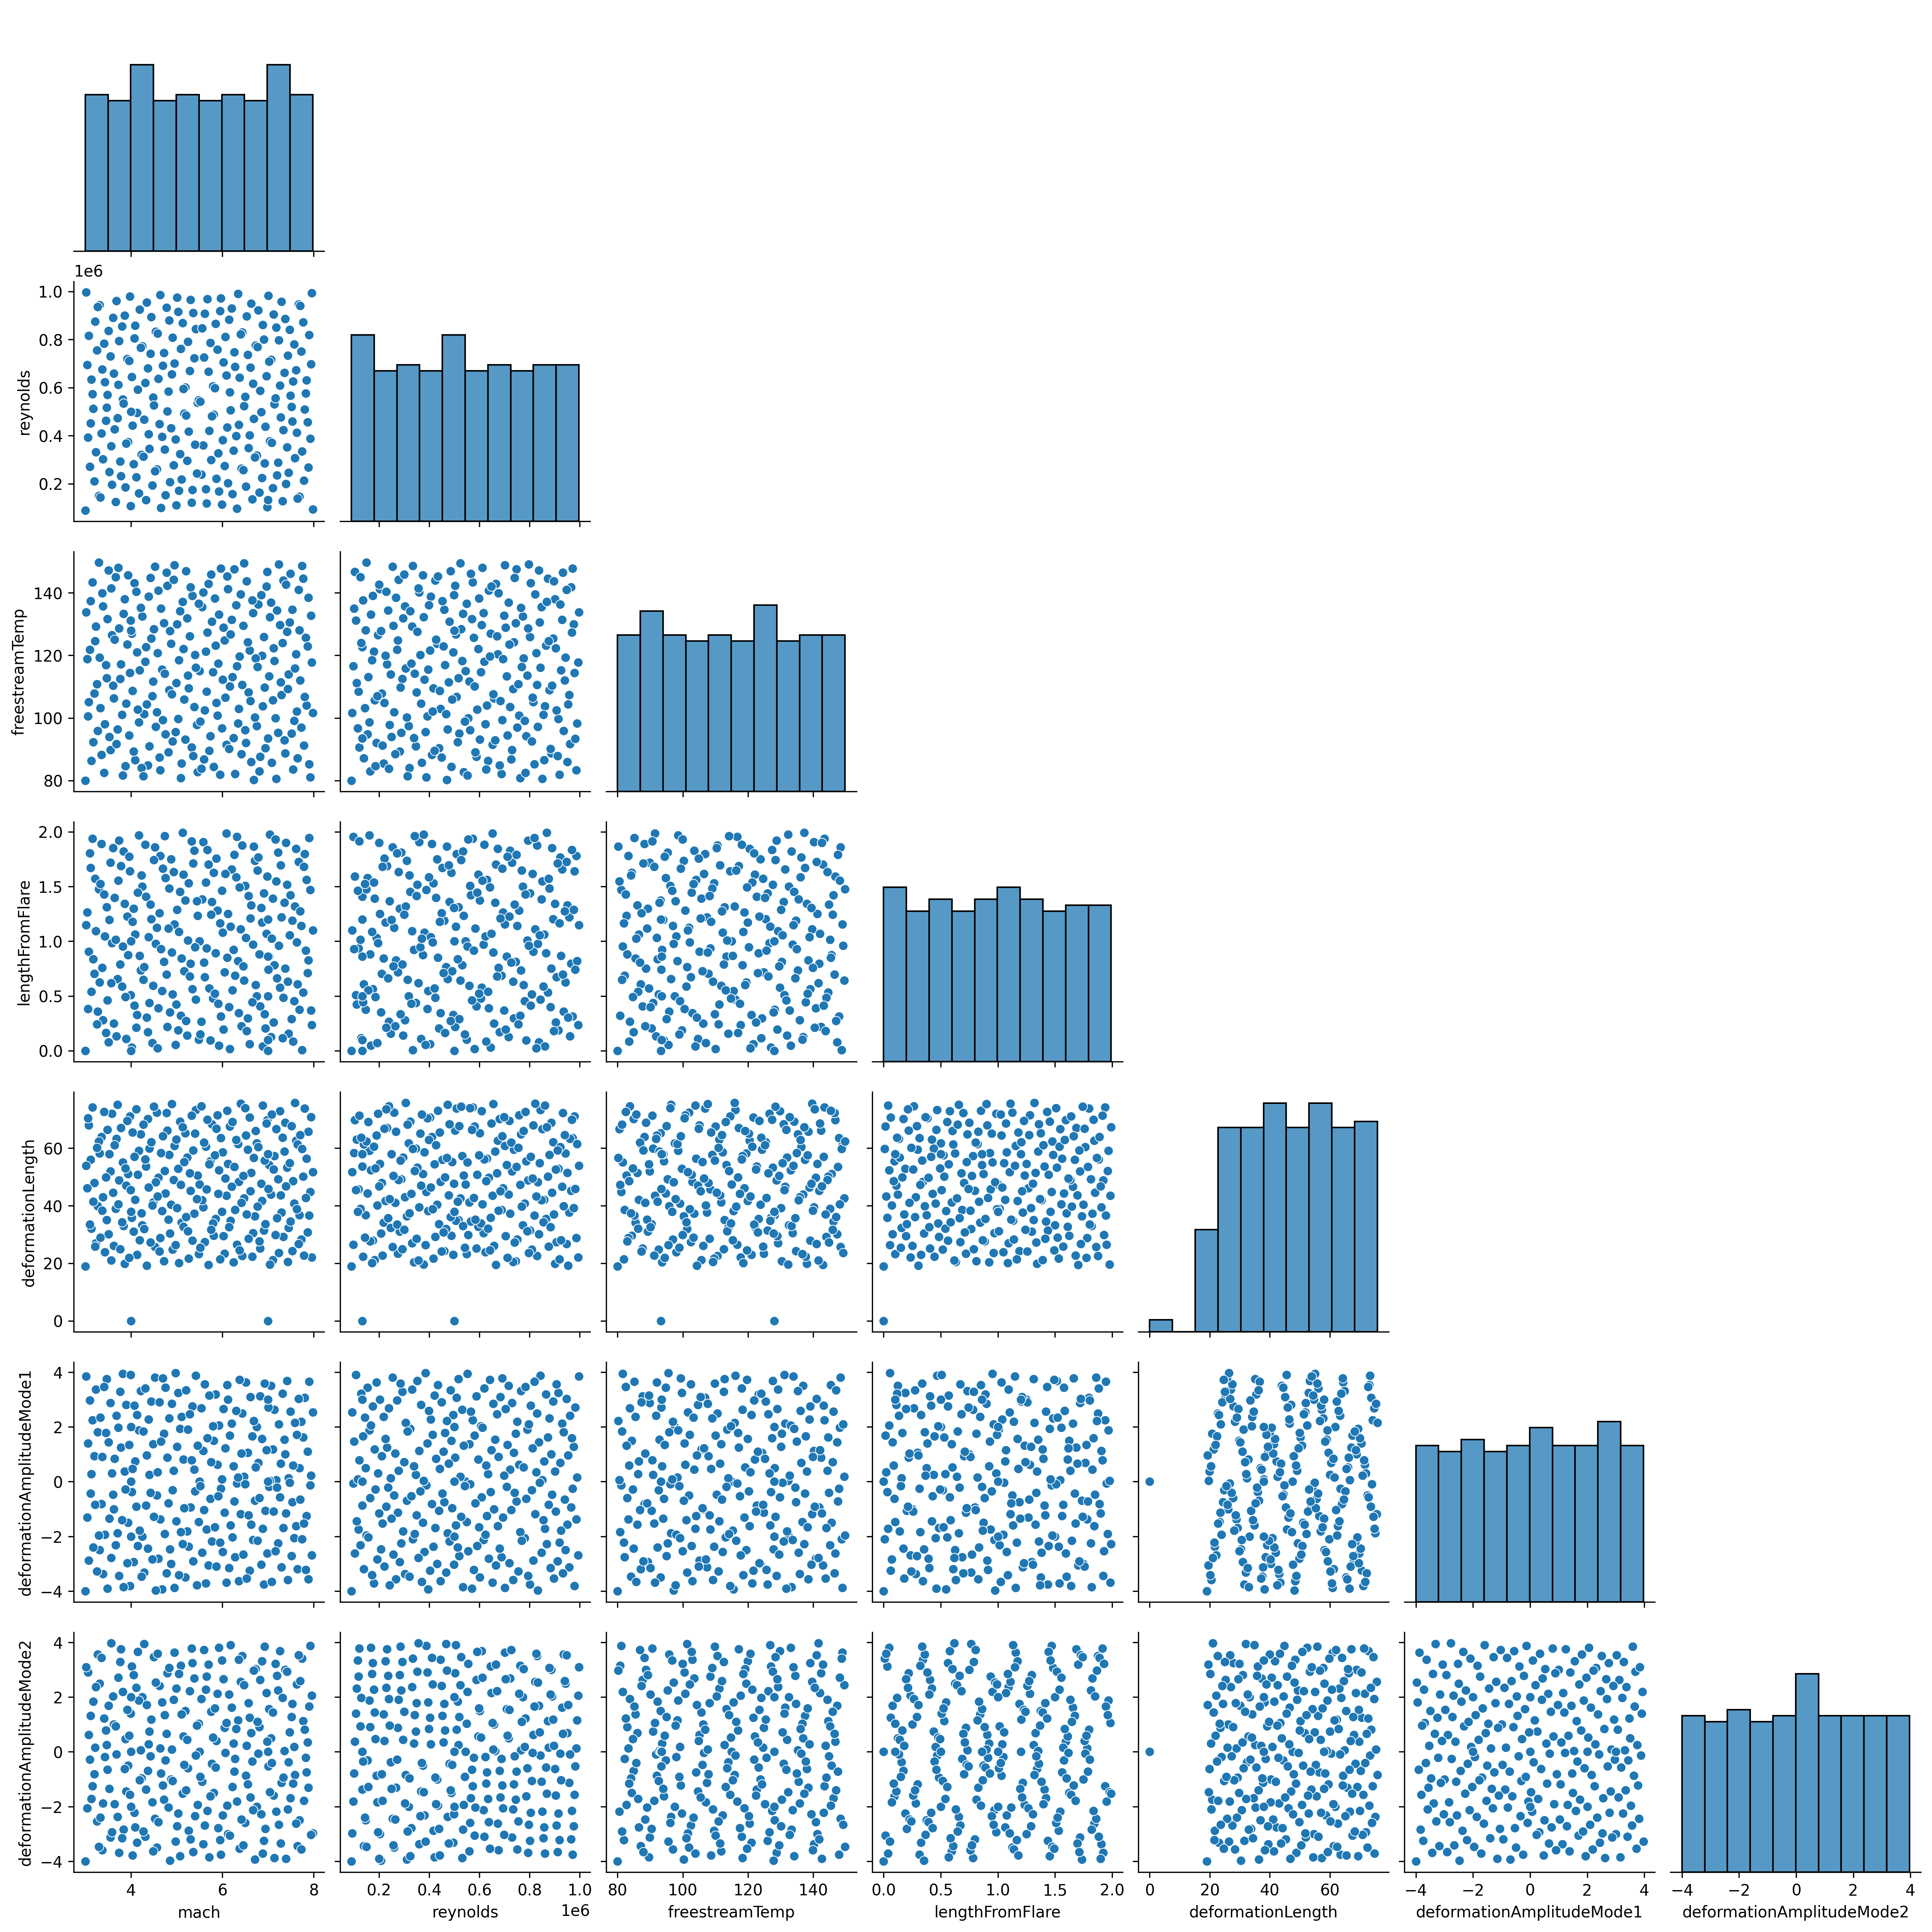

In [8]:
# locationFromFlareDF = pd.DataFrame(data = sampleArray[:,locationOfLengthFromFlare])
# sns.histplot(locationFromFlareDF)
# sns.set(font_scale=1)
selectedVariables = inputParamNames

# columnRenameDict = {
#     'mach': 'Mach',
#     'reynolds': 'Reynolds Number',
#     'deformationAmplitude': 'Deformation Amplitude',
#     'deformationLength': 'Deformation Length'
# }

df_new = df[selectedVariables]
# df_new = df_new.rename(columns=columnRenameDict)
sns.pairplot(df_new, corner=True)

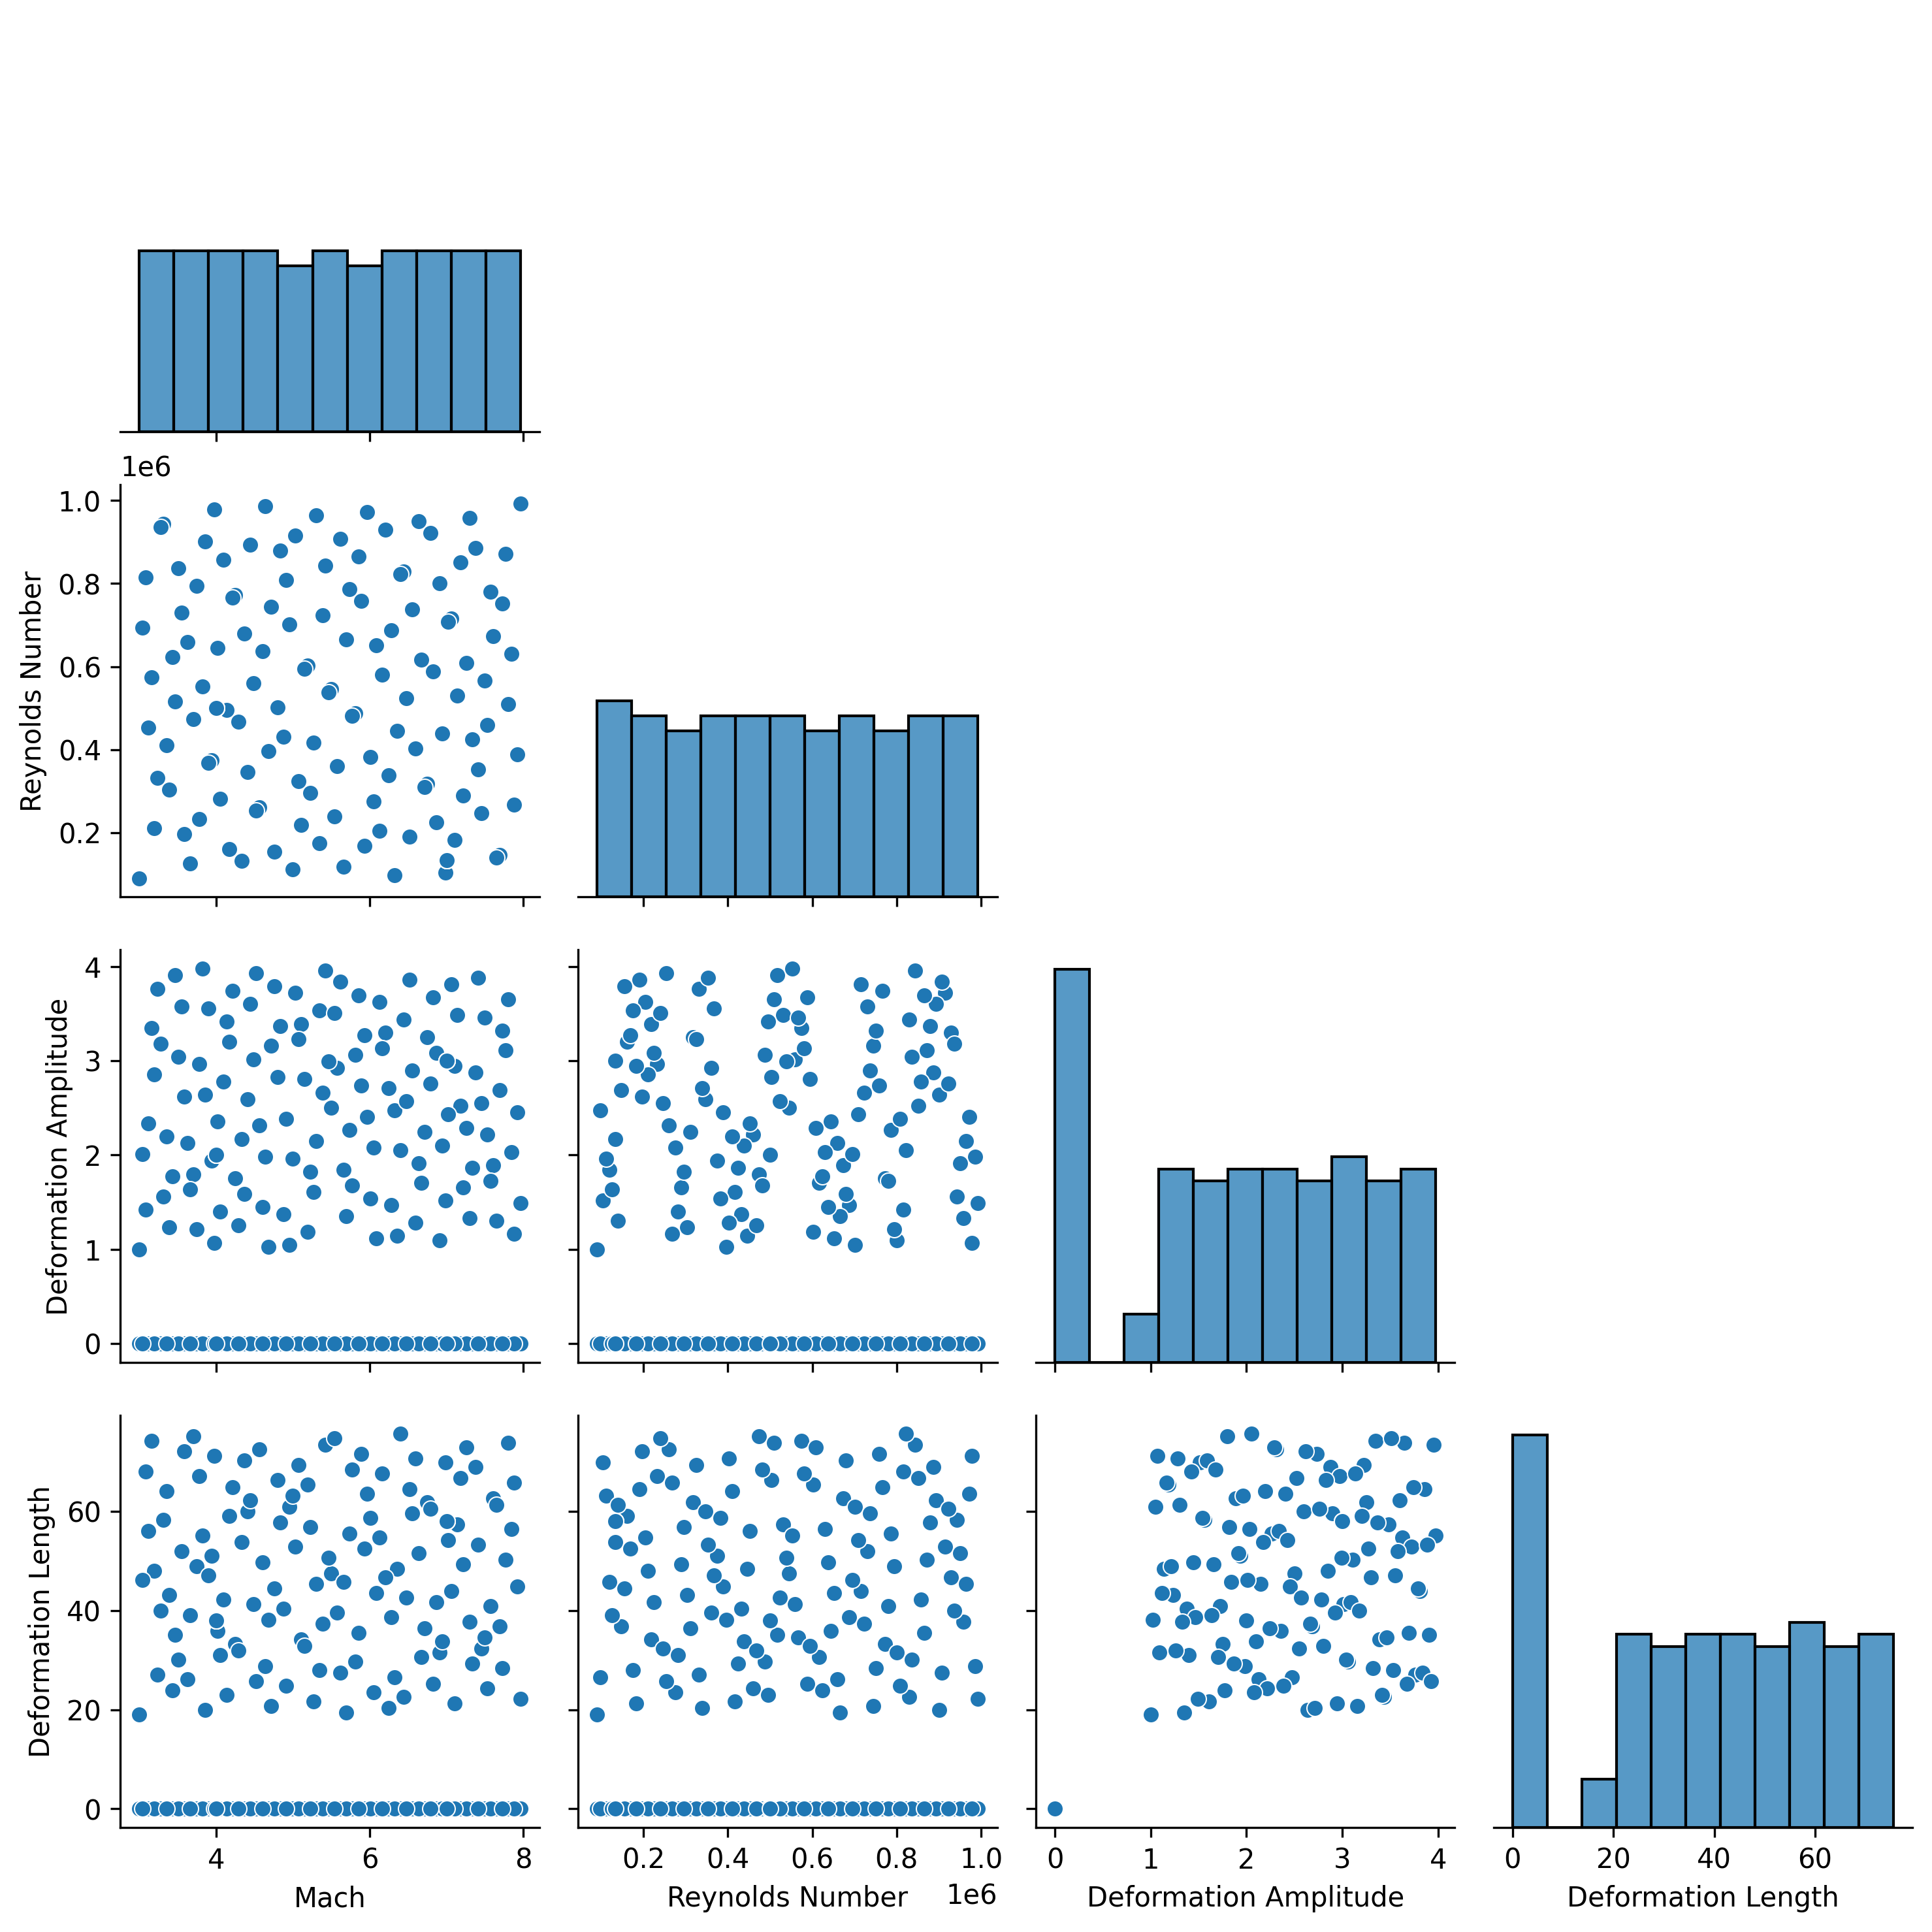

In [8]:
# # locationFromFlareDF = pd.DataFrame(data = sampleArray[:,locationOfLengthFromFlare])
# # sns.histplot(locationFromFlareDF)
# # sns.set(font_scale=1)
# selectedVariables = ['mach', 'reynolds', 'deformationAmplitude', 'deformationLength']

# columnRenameDict = {
#     'mach': 'Mach',
#     'reynolds': 'Reynolds Number',
#     'deformationAmplitude': 'Deformation Amplitude',
#     'deformationLength': 'Deformation Length'
# }

# df_new = df[selectedVariables]
# df_new = df_new.rename(columns=columnRenameDict)
# sns.pairplot(df_new, corner=True)

In [32]:
mat = scipy.io.loadmat('defslopecurv.mat')

def removekey(d, key):
    r = dict(d)
    del r[key]
    return r

delKeysList = ['__header__', '__version__', '__globals__']
for key in delKeysList:
    mat = removekey(mat,key)
    
columnNames = [keyname for keyname in mat.keys()]

In [45]:
aaronDict = {}
for key in mat.keys():
    aaronDict[key] = mat[key].reshape(-1,)
    # print(aaronDict[key].shape)
aaronDF = pd.DataFrame.from_dict(aaronDict)

In [50]:
aaronDF.keys()

Index(['maxcurv1', 'maxcurv1location', 'maxcurv2', 'maxcurv2location',
       'maxdef', 'maxdeflocation', 'maxslope1', 'maxslope1location',
       'maxslope2', 'maxslope2location', 'mincurv1', 'mincurv1location',
       'mincurv2', 'mincurv2location', 'mindef', 'mindeflocation', 'minslope1',
       'minslope1location', 'minslope2', 'minslope2location'],
      dtype='object')

In [67]:
concatDF = pd.concat([aaronDF,df],axis=1)
# concatDF.shape

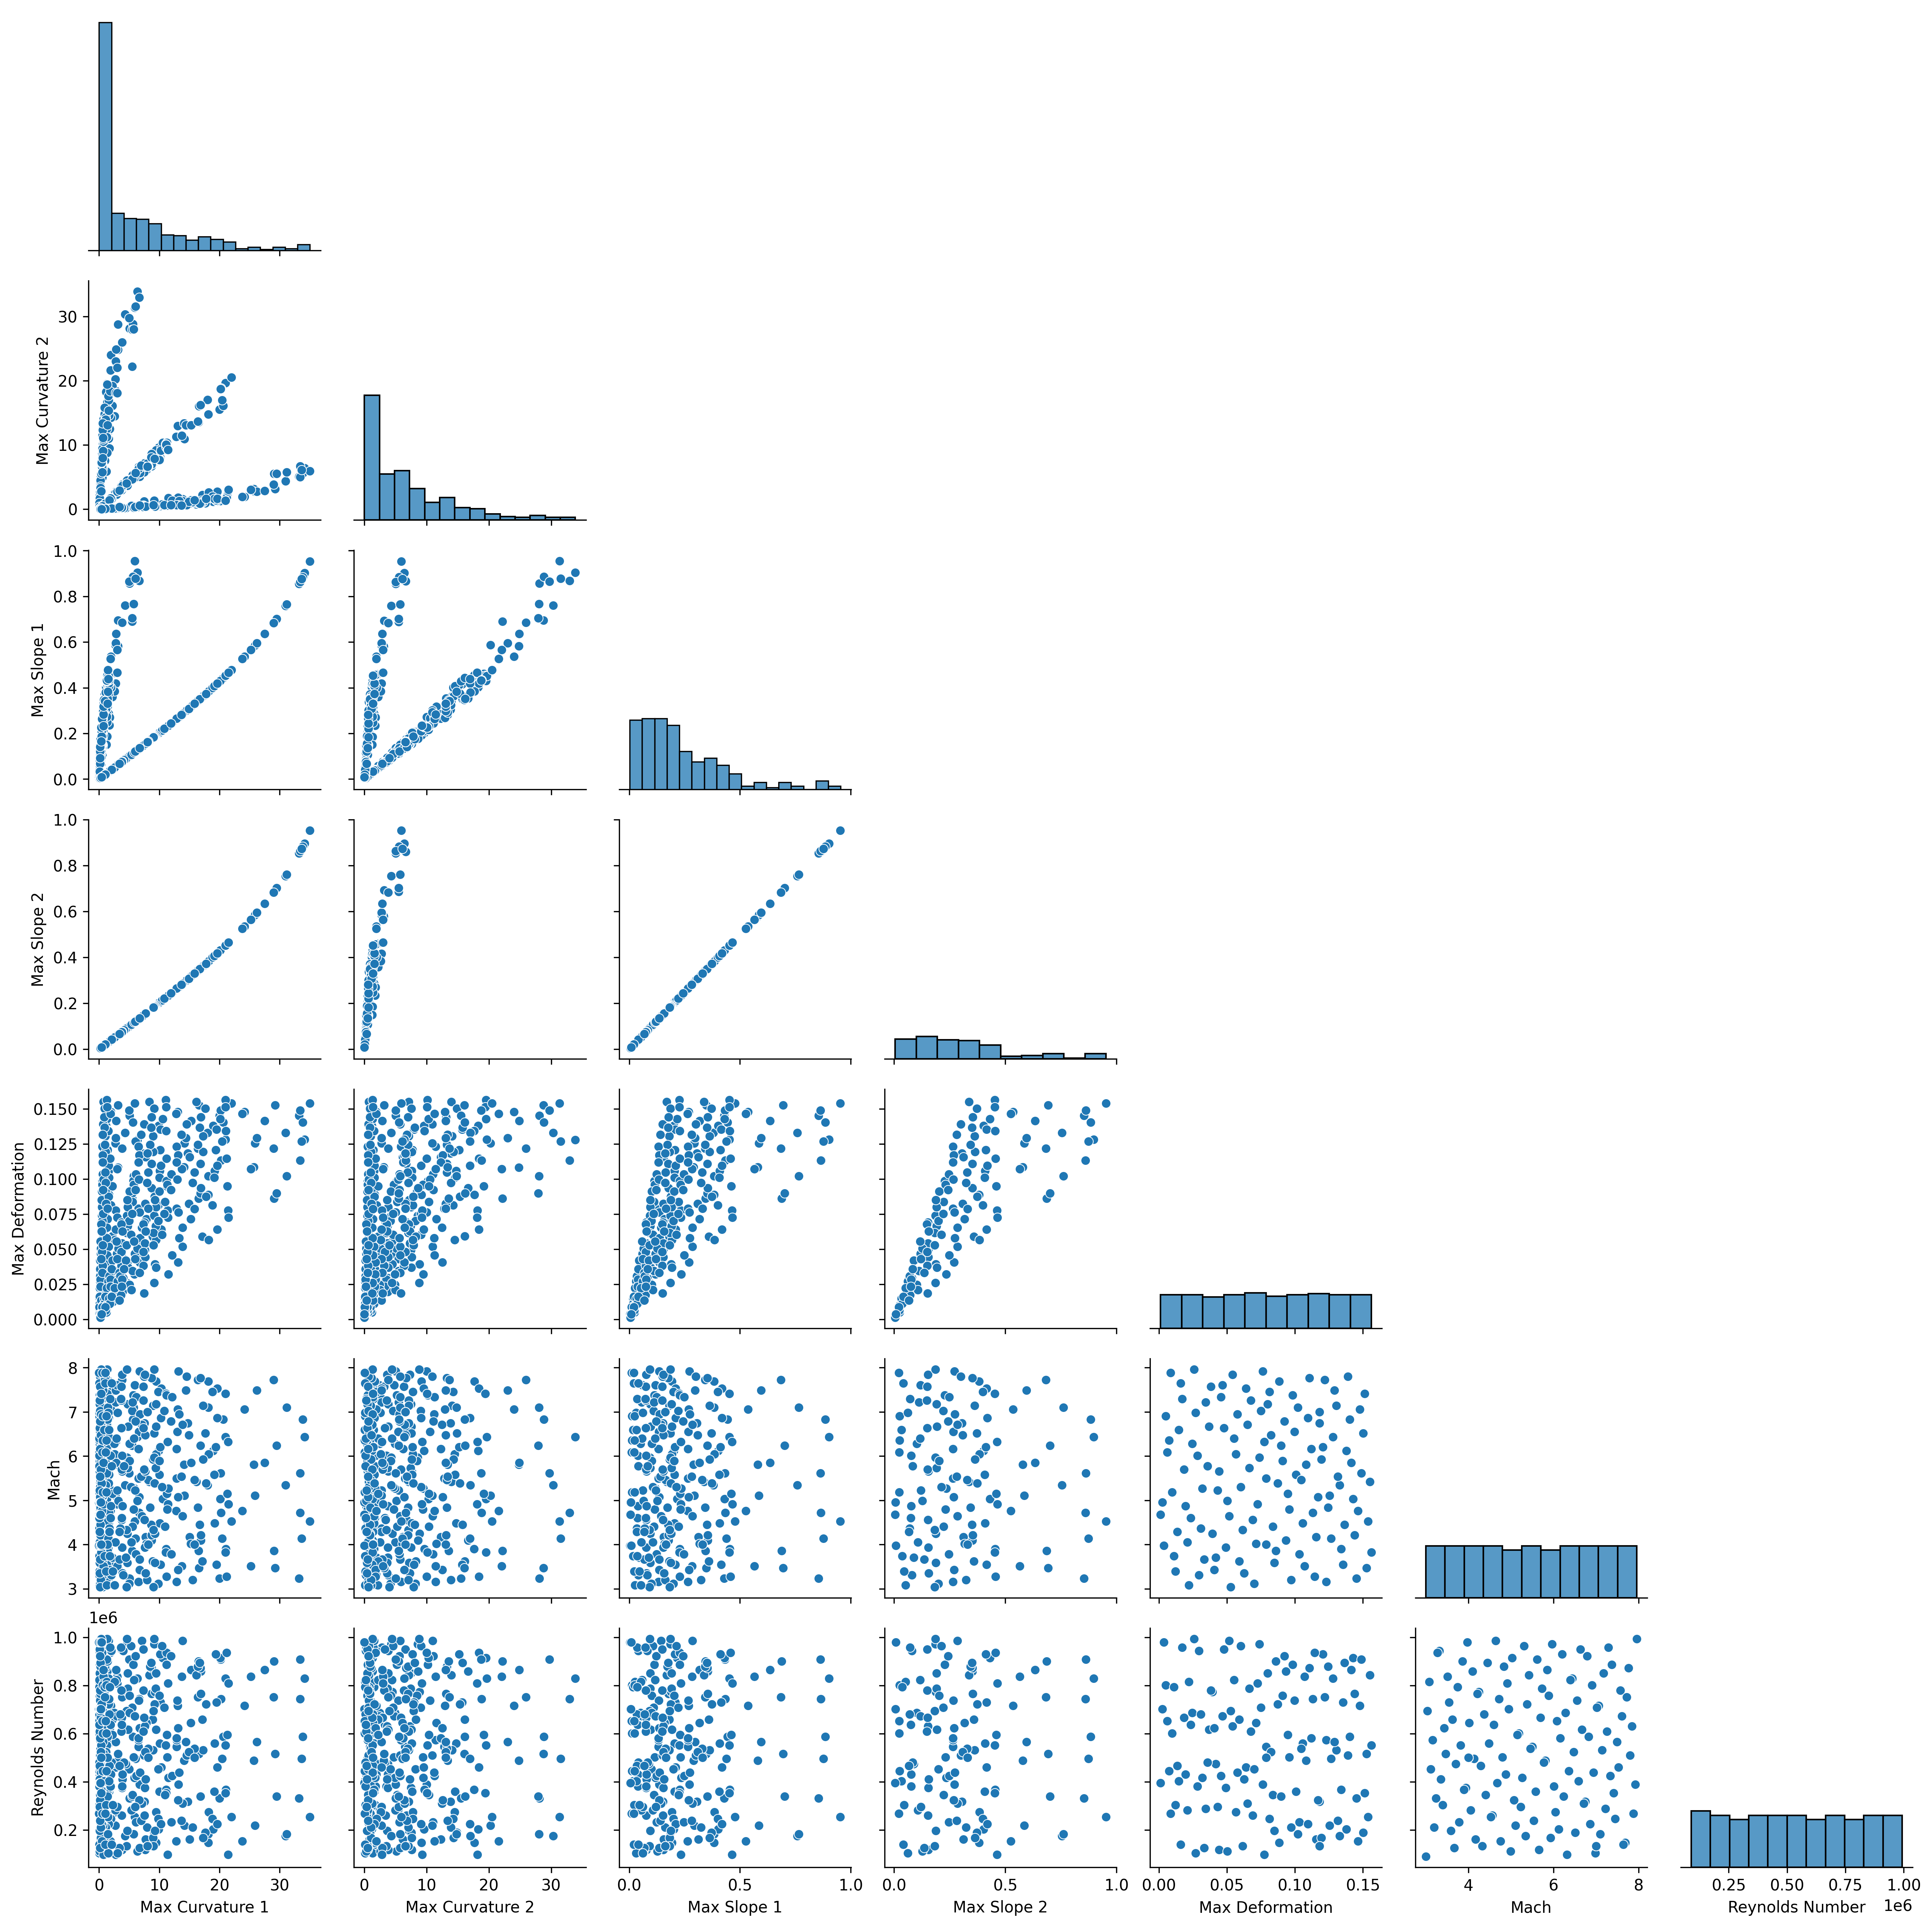

In [68]:
selectedVariables = ['maxcurv1', 'maxcurv2', 'maxslope1', 'maxslope2', 'maxdef', 'mach', 'reynolds']

columnRenameDict = {
    'maxcurv1': 'Max Curvature 1', 
    'maxcurv2': "Max Curvature 2", 
    'maxslope1': 'Max Slope 1', 
    'maxslope2': 'Max Slope 2',
    'maxdef': 'Max Deformation',
    'mach': 'Mach',
    'reynolds': 'Reynolds Number'
}

df_new = concatDF[selectedVariables]
df_new = df_new.rename(columns=columnRenameDict)
sns.pairplot(df_new, corner=True)